## setup and notebook configuration

In [1]:
import numpy as np
import time
import orthopy

In [166]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri               # delaunay triangulation
from mpl_toolkits.mplot3d import Axes3D     # surface plotting
import seaborn as sns
import cmocean as cmo
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [163]:
import src.fem_base.master.mk_master as mkm
from src.plot.trianguation_plotting_2D import colorbar_data_normed

# 2D nodal basis

## triangle

### what's wrong with what's there

We will define our master triangle following the strange (but legacy) MPU convention of the points below, which is the opposite way from which the master element is usually defined. Note that 
- MPU shifts the nodal points -- this is a good thing, but the user should have control over it
- there are serious performance issues with high order elements due to the use of sympy and symbolic gram-schmidt as an initialization technique. THERE MUST BE A BETTER WAY


We would like to re-write `Master_nodal` to be a bit more modular and flexible, as well as less differently-abled in terms of code organization

In [4]:
mt = mkm.Master_nodal(order=3, dim=2, element=0)

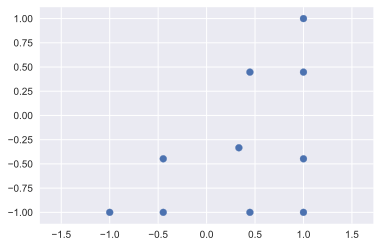

In [5]:
fig, ax = plt.subplots()
plt.scatter(mt.nodal_pts[:,0], mt.nodal_pts[:,1])
ax.axis('equal')
plt.show()

We can run the following benchmarking code (expensive), and generate a plot of wallclock time for master element initialization.

```python
master_init_times = []
for p in range(1, 11):
    start = time.clock()
    master_obj = mkm.Master_nodal(order=p, dim=2, element=0)
    end = time.clock()
    elapsed = end - start
    master_init_times.append(elapsed)
```

from which we plot
<img src="img/MPU_master_tri_init_times.png" alt="drawing" style="width: 500px;"/>

this is really slow. If we would like to play with higher order elements, we need a more efficient way of initializing these master elements.

### barycentric coordinate tools

The following define the transformation to and from barycentric coordinates from cartesian coords.

In [6]:
# %load -s cart2bary,bary2cart ../src/fem_base/master/barycentric_coord_tools.py
def cart2bary(verts, pts):
    """ retrns barycentric coords of pt on a tri w/ vertices verts
    @param verts tuple of tuples specifying verts
    @param pt  numpy array of point on triangle shape (2, npts)
    """
    npts = pts.shape[1]
    _lambda = np.zeros((3, npts))
    (x1, y1), (x2, y2), (x3, y3) = verts
    T = np.array([[x1 - x3, x2 - x3],
                  [y1 - y3, y2 - y3]])
    r = np.copy(pts)
    r[0,:] -= x3
    r[1,:] -= y3

    _lambda[:2, :] = np.linalg.solve(T, r)
    _lambda[2, :] = 1 - _lambda[0,:] - _lambda[1,:]
    return _lambda

def bary2cart(verts, _lambda):
    """converts from barycentric to cartesian coordinates
    @param verts  tuple of tuples specifying triangle vertices
    @param _lambda array of barycentric points (3, npts)
    """
    npts = _lambda.shape[1]
    λ1, λ2, λ3 = _lambda[0,:], _lambda[1,:], _lambda[2,:]
    x, y = np.zeros(npts), np.zeros(npts)
    (x1, y1), (x2, y2), (x3, y3) = verts
    x = λ1*x1 + λ2*x2 + λ3*x3
    y = λ1*y1 + λ2*y2 + λ3*y3
    return x, y


The following generates the barycentric coordinates corresponding to uniform nodes on a triangle for a polynomial order $p$.

In [92]:
# %load -s uniform_bary_coords ../src/fem_base/master/barycentric_coord_tools.py
def uniform_bary_coords(p):
    """ generate bary coords of uniform nodal pts for tri of order p"""
    N, Np = p, int((p+1)*(p+2)/2)
    node = 0
    bary = np.zeros((3, Np))
    for i in range(N+1):
        for j in range(N+1-i):
            λ1, λ2 = i/N, j/N
            λ3 = 1 - λ1 - λ2
            bary[:, node] = np.asarray([λ1, λ2, λ3])
            node += 1
    return bary


In [178]:
p = 16
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
x, y = bary2cart(verts, bary)

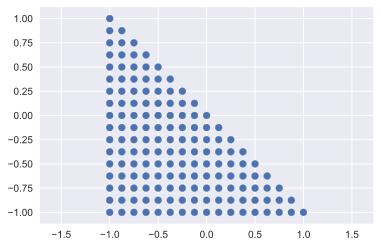

In [179]:
plt.scatter(x, y)
plt.axis('equal')
plt.show()

### underlying polynomial modal basis

We need a way to generalize the 1D orthonormal polynomial basis to that over the standard simplex

$$T \equiv \{\mathbf{r}=(\xi, \eta) \mid (\xi, \eta) \leq -1; \xi+\eta \leq0\}$$

such that we can efficiently compute $\psi_m(\mathbf{r})$ over $T$. In Hesthaven and Warburton, the suggestion is to use the basis defined by

\begin{align}
   m(i,j) &= j + (N+1)i + 1 - \frac{i}{2}(i-1) \\
   \psi_m(\mathbf{r}) &= \sqrt{2} P_i(a) \, P_j^{(2i+1, 0)}(b)\, (1-b)^i \\
   &a = 2 \frac{1+\xi}{1-\eta} - 1, b=\eta
\end{align}

Where $P_n^{(\alpha, \beta)}$(x) is the familiar $n^{th}$ order Jacobi polynomial over [-1, 1] discussed in depth in the `1D_basis_and_master` tutorial.

In order to position points on the triangle, it will be convenient to work in [Barycentric coordinates](https://en.wikipedia.org/wiki/Barycentric_coordinate_system).

In [180]:
# %load ../src/fem_base/master/polynomials_2D.py
#!/usr/bin/env python

import numpy as np
import orthopy

import src.fem_base.master.barycentric_coord_tools as bct
from src.fem_base.master.master_2D import MASTER_ELEMENT_VERTICES

# define vertices on master elements as specified in master_2D.py
MASTER_TRI_VERTS = MASTER_ELEMENT_VERTICES['TRIANGLE']

def mk_m2ij(p):
    """ returns a list A for which A[m] = (i,j) for orthopy polynomials psi_m"""
    return [(j,i) for i in range(p) for j in range(i+1)]

def ortho_triangle(bary, p):
    """ wraps orthopy, returns tree of orthonormal polys over bary coords
    @param bary  barycentric points on a triangle at which to eval polynomials
    @param p  the order of the basis -- how many polynomials we want
    @retval polys (npts, m) array of psi_m at the npts

    orthopy returns a list of arrays, where `out[k]` hosts the `2*k+1`
    values of the `k`th level of the tree
        (0, 0)
        (0, 1)   (1, 1)
        (0, 2)   (1, 2)   (2, 2)
          ...      ...      ...   (i, j)
    so we unpack the (i,j) into the index m via m2ij above.
    """
    m2ij = mk_m2ij(p)
    ortho_output = orthopy.triangle.tree(bary, n=p, standardization='normal')
    npts, npolys = bary.shape[1], len(m2ij)
    polys = np.zeros((npts, npolys))
    for m, (i,j) in enumerate(m2ij):
        polys[:,m] = ortho_output[j][i,:]
    return polys

def P_tilde(pts, p, verts=MASTER_TRI_VERTS):
    """ generates the values of the orthonormal modal polynomials at pts r on the reference tri
    @param verts  tuple of tuples specifying the CCW vertices of the triangle in question
    @param pts  points defined on the triangle defd by verts (npts, 2)
    @param p  order of the orthonormal polynomial basis to be generated
    """
    bary_coords = bct.cart2bary(verts, pts.T)
    polys = ortho_triangle(bary_coords, p+1)
    return polys


In [181]:
xy = np.vstack((x, y)).T
xy.shape
pp = P_tilde(xy, p)
pp.shape, x.shape

((153, 153), (153,))

need a good way of drawing the polys and the shape functions over the reference triangle

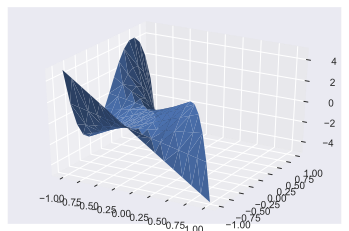

In [182]:
fig = plt.figure()

tri = mtri.Triangulation(x, y)
ax = fig.add_subplot(1, 1, 1, projection='3d')
cax = ax.plot_trisurf(tri, pp[:,7])

now let's see if we can make the nodal shape functions.

In [183]:
p = 2
Np = int((p+1)*(p+2)/2)
bary = uniform_bary_coords(p)
verts = ((-1, -1), (-1, 1), (1, -1))
xp, yp = bary2cart(verts, bary)
xy = np.vstack((xp, yp)).T
V2D = P_tilde(xy, p)
print(V2D.shape)
Ptil = pp[:,0:6]
print(Ptil.shape)
Vti = np.linalg.inv(V2D.T)
yy = np.dot(Vti, Ptil.T)
yy.shape

(6, 6)
(153, 6)


(6, 153)

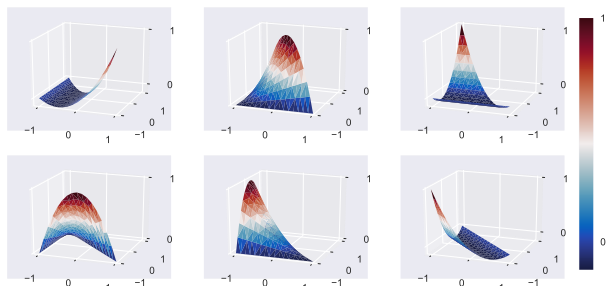

In [227]:
fig = plt.figure(figsize=(10, 5))
data = yy[4,:]

nb = yy.shape[0]
tri = mtri.Triangulation(x, y)
for i in range(nb):
    data = yy[i,:]
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.set_xticks([-1, 0, 1]); ax.set_yticks([-1,0,1]); ax.set_zticks([0,1]);
    cax = ax.plot_trisurf(tri, data, cmap=cmo.cm.balance)
    ax.view_init(elev=20, azim=-70)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
m = colorbar_data_normed(data, cmo.cm.balance)
fig.colorbar(m, ticks=[0, 1], cax=cbar_ax)
plt.show()

In [185]:
np.max(yy[4,:])

0.9999999999999999

In [ ]:
def xi_eta_to_ab(ξ, η):
    """ function to transform xi, eta coords to a, b
    see Hesthaven function 'rstoab'
    @param xi, eta vectors of xi, eta pts
    """
    a, b = np.zeros_like(xi), np.zeros_like(eta)
    a = 2*(1. + ξ)/(1 - η)
    b = η
    return a, b

## quadrilateral

# TODO

- unit test where we transform from bary 2 cart 2 bary again